In [1]:
# This calculates MJDs and BJDs of light curve maxima, as observed at MacAdam, U Louisville, and Mt. Kent in Australia

# created 2018 Jan 02 by E.S.

In [1]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from datetime import datetime
from astropy import time, coordinates as coord, units as u
from astropy.time import Time
from dateutil.parser import parse

In [8]:
df = pd.read_csv('czw.20190823.robospect.txt', delim_whitespace=True, header=1)

In [9]:
df.keys()

Index(['#inputWavelength', 'inputFlux', 'inputErrorPlacehldr',
       'modelContinuum', 'modelError', 'modelLines', 'modelAlternate'],
      dtype='object')

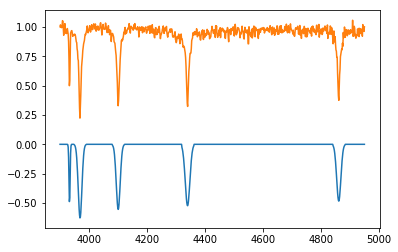

In [12]:
plt.plot(df["#inputWavelength"],df["modelLines"])
plt.plot(df["#inputWavelength"],df["inputFlux"])
plt.savefig('model_lines.pdf')

In [2]:
photometry_jd = pd.read_csv('macadam_photometry_epochs_jd.csv')

In [3]:
photometry_jd

,star,observatory,jd
0,RW Ari,mso,2.456314e+06
1,X Ari,mso,2.456601e+06
2,UY Cam,ulmo,2.456576e+06
3,RR Cet,mso,2.456577e+06
4,SV Eri,mtkent,2.456580e+06
5,VX Her,ulmo,2.456576e+06
6,RR Leo,ulmo,2.456605e+06
7,TT Lyn,mso,2.456607e+06
8,TV Lyn,mso,2.456312e+06
9,TW Lyn,mso,2.456607e+06


In [4]:
########################################
## FIND HJDs, BJDs
########################################

In [5]:
# set observatory coordinates 

loc_mcdonald = coord.EarthLocation.from_geodetic(lon=-104.0215753,lat=30.6715396,height=2076,ellipsoid='WGS84')
loc_macadam = coord.EarthLocation.from_geodetic(lon=-84.503712,lat=38.033891,height=298,ellipsoid='WGS84')
loc_mtKent = coord.EarthLocation.from_geodetic(lon=151.856013,lat=-27.797847,height=682,ellipsoid='WGS84')
loc_ulmo = coord.EarthLocation.from_geodetic(lon=-85.528732,lat=38.344787,height=142,ellipsoid='WGS84')

In [6]:
# make time objects

photometry_times = Time(photometry_jd['jd'], format='jd')

In [7]:
mjdTimes = photometry_times.mjd

In [21]:
photometry_jd['jd'][0]

2456313.55198

In [19]:
mjdTimes

array([ 56313.05198 ,  56600.114467,  56575.275563,  56576.212696,
        56579.532443,  56575.05286 ,  56604.446028,  56606.305239,
        56311.168063,  56606.414045,  56465.162852,  56610.344004,
        56485.250582,  56593.085144,  56563.127096,  56574.247057,
        56602.262516,  56275.320087,  56679.270138])

In [7]:
# fcn to convert MJD to BJD times

def convert_mjd_to_bjd(mjdTimes,observatoryLoc,skyCoordObj):

    timesObj = time.Time(mjdTimes, format='mjd', scale='utc', location=observatoryLoc)
    ltt_bary = timesObj.light_travel_time(skyCoordObj)
    
    time_barycentre = timesObj.tdb + ltt_bary 
        
    # note the returned type is still mendaciously called 'mjd' 
    return np.add(time_barycentre.mjd,0.5) # I think 0.5 day is missing from the code

In [8]:
# fcn to convert MJD to HJD times

def convert_mjd_to_hjd(mjdTimes,observatoryLoc,skyCoordObj):

    timesObj = time.Time(mjdTimes, format='mjd', scale='utc', location=observatoryLoc)
    ltt_helio = timesObj.light_travel_time(skyCoordObj, 'heliocentric')
    
    times_heliocentre = timesObj.utc + ltt_helio 
        
    # note the returned type is still mendaciously called 'mjd' 
    return np.add(times_heliocentre.mjd,0.5) # I think 0.5 day is missing from the code

In [19]:
# read in star name, return file names and BJDs of spectra observations

def return_star_epochs_photometry(starNames,jdTimes,observatoryLocs):
    # returns cols of MJD, HJD, and BJD
    
    if len(starNames) != len(jdTimes): # something must be wrong!
        return
    
    # initialize a pandas dataframe
    df = pd.DataFrame()
    
    # convert jds to mjds
    mjdTimes = jdTimes.mjd
    
    thisStar = []
    observatoryThisStar = []
    jdThisStar = []
    mjdThisStar = []
    hjdThisStar = []
    bjdThisStar = []
    
    # go through each row in file
    for t in range(0,len(jdTimes)): 
        
        # make a star coordinate object
        coord_thisStar = coord.SkyCoord.from_name(starNames[t])
        
        # determine observatory location
        if (observatoryLocs[t] == 'mso'): observ_thisStar = loc_macadam 
        if (observatoryLocs[t] == 'mtkent'): observ_thisStar = loc_mtKent 
        if (observatoryLocs[t] == 'ulmo'): observ_thisStar = loc_ulmo 
        
        thisStar.append(starNames[t])
        observatoryThisStar.append(observatoryLocs[t])
        jdThisStar.append(jdTimes[t].jd)
        mjdThisStar.append(mjdTimes[t])
        hjdThisStar.append(convert_mjd_to_hjd(mjdTimes[t],observ_thisStar,coord_thisStar))
        bjdThisStar.append(convert_mjd_to_bjd(mjdTimes[t],observ_thisStar,coord_thisStar)) 
                
    df['star'] = thisStar
    df['observatory'] = observatoryThisStar
    df['jd'] = jdThisStar
    df['mjd'] = mjdThisStar
    df['hjd'] = hjdThisStar
    df['bjd'] = bjdThisStar
    
    return df

In [20]:
# find 

photometryEpochs = return_star_epochs_photometry(photometry_jd['star'],photometry_times,photometry_jd['observatory'])

In [21]:
# write out csv

photometryEpochs.to_csv('junk.csv')

In [22]:
photometryEpochs

,star,observatory,jd,mjd,hjd,bjd
0,RW Ari,mso,2.456314e+06,56313.051980,56313.552637,56313.553400
1,X Ari,mso,2.456601e+06,56600.114467,56600.620123,56600.620893
2,UY Cam,ulmo,2.456576e+06,56575.275563,56575.775787,56575.776556
3,RR Cet,mso,2.456577e+06,56576.212696,56576.718396,56576.719171
4,SV Eri,mtkent,2.456580e+06,56579.532443,56580.037196,56580.037967
5,VX Her,ulmo,2.456576e+06,56575.052860,56575.549740,56575.550526
6,RR Leo,ulmo,2.456605e+06,56604.446028,56604.945113,56604.945880
7,TT Lyn,mso,2.456607e+06,56606.305239,56606.806398,56606.807163
8,TV Lyn,mso,2.456312e+06,56311.168063,56311.673073,56311.673840
9,TW Lyn,mso,2.456607e+06,56606.414045,56606.916515,56606.917279


In [46]:
# show

dfAll

,filenames,mjd,bjd,elapsed_bjd_since_spec_01
0,RW_Ari_02.fits,56288.129929,56288.633699,0.039824
1,RW_Ari_01.fits,56288.090101,56288.593874,0.000000
2,RW_Ari_03.fits,56288.169575,56288.673341,0.079467
3,RW_Ari_04.fits,56289.084369,56289.588057,0.994182
4,RW_Ari_05.fits,56289.135552,56289.639235,1.045361
0,X_Ari__01.fits,56283.141155,56283.646050,0.000000
1,X_Ari__02.fits,56283.149084,56283.653979,0.007929
2,X_Ari__03.fits,56283.209298,56283.714188,0.068138
3,X_Ari__04.fits,56283.263945,56283.768832,0.122782
4,X_Ari__05.fits,56283.275771,56283.780657,0.134607
